# Mercari Price Suggestion Challenge
---

Link: https://www.kaggle.com/c/mercari-price-suggestion-challenge

|columns | desc|
|:-|:-|
|id| train or test|
|name| the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. \$20) to avoid leakage. These removed prices are represented as [rm]|
|item_condition_id|the condition of the items provided by the seller|
|category_name|category of the listing|
|brand_name|brand_name|
|price|the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in "test.tsv" since that is what you will predict|
|shipping|1 if shipping fee is paid by seller and 0 by buyer|
|item_description|the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]|

In [1]:
import mmap

def get_num_lines(file_path):
    """
    Return text lines fastly
    https://blog.nelsonliu.me/2016/07/29/progress-bars-for-python-file-reading-with-tqdm/
    """
    
    fp = open(file_path, "r+")
    buf = mmap.mmap(fp.fileno(), 0)
    lines = 0
    while buf.readline():
        lines += 1
    return lines

In [2]:
get_num_lines('./data/train.tsv') - 1  # safe to load in pandas

1482535

In [3]:
get_num_lines('./data/test.tsv') - 1

693359

In [4]:
df = pd.read_csv('./data/train.tsv', sep='\t')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [6]:
df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

## EDA

In [7]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [8]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


* Item Condition, Shipping

In [9]:
df_condition = df.item_condition_id.value_counts()
df_shipping = df.shipping.value_counts()

pct1 = ['{0:.2f}%'.format(y/df_condition.sum()*100) for y in df_condition.values]
pct2 = ['{0:.2f}%'.format(y/df_shipping.sum()*100) for y in df_shipping.values]

bar1 = go.Bar(x=df_condition.index.values, y=df_condition.values, text=pct1, name='',
              marker=dict(color=df_condition.values, colorscale='Portland', opacity=0.99))
bar2 = go.Bar(x=df_shipping.index.values, y=df_shipping.values, text=pct2, name='',
              marker=dict(color=df_shipping.values, colorscale='Viridis', opacity=0.7))
layout = go.Layout(showlegend=False,
                   xaxis1=dict(title='Item_condition_id'),
                   yaxis1=dict(title='Count'),
                   xaxis2=dict(title='Shipping',
                               ticktext=['Seller', 'Buyer'],
                               tickvals=[0, 1]),
                   yaxis2=dict(title='Count'))
fig = plotly.tools.make_subplots(rows=1, cols=2, 
                                 subplot_titles=('Item Condition Count', 
                                                 'Shipping Fee is Paid by Whom?'))
fig.append_trace(bar1, 1, 1)
fig.append_trace(bar2, 1, 2)
fig.update(layout=layout)
plotly.offline.plot(fig, filename='./EDA_fig/item_condition_and_shipping.html')
# plotly.offline.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



'file:///Users/Soo/code/gitproject/Mercari_Price/EDA_fig/item_condition_and_shipping.html'

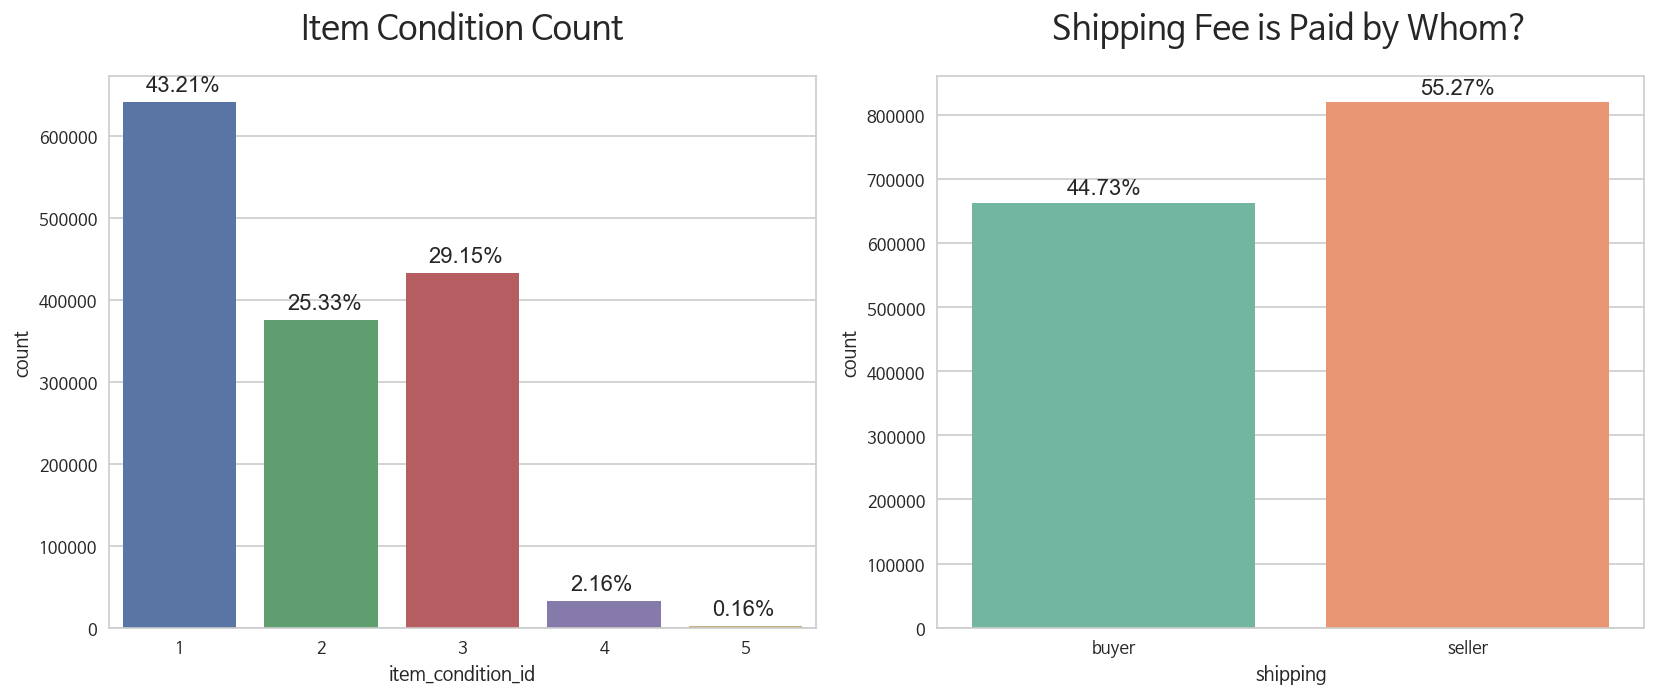

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
sns.set(font_scale=1.1)
sns.countplot('item_condition_id', data=df, ax=ax1)
df_ship = df[['shipping']].replace({0: 'seller', 1: 'buyer'})
sns.countplot('shipping', data=df_ship, ax=ax2, palette='Set2')
ax1.set_title('Item Condition Count', fontsize=20, y=1.05)
ax2.set_title('Shipping Fee is Paid by Whom?', fontsize=20, y=1.05)
total = len(df_ship)

for ax in [ax1, ax2]:
    for p in ax.patches:
        b = 1/5 if ax is ax1 else 1/3
        ax.text(p.get_x()+p.get_width()*b, p.get_height() + total*0.009, 
                '{:.2f}%'.format(p.get_height()/total*100))
plt.tight_layout()
plt.show()

Most of Item Conditions are at 1,2,3. Maybe lower numbers are in good conditions.

Seller paid shipping fee more than buyers.

* Price

In [9]:
df.price.describe().round(3)

count    1482535.000
mean          26.738
std           38.586
min            0.000
25%           10.000
50%           17.000
75%           29.000
max         2009.000
Name: price, dtype: float64

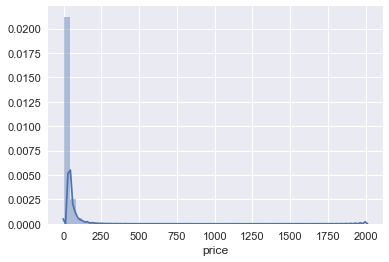

In [10]:
sns.distplot(df.price)

In [11]:
cnts, bins = np.histogram(df.price, bins=10)

In [12]:
pd.DataFrame({'bins': bins[1:], 'counts': cnts})

,bins,counts
0,200.9,1472289
1,401.8,8335
2,602.7,1169
3,803.6,399
4,1004.5,178
5,1205.4,65
6,1406.3,47
7,1607.2,21
8,1808.1,16
9,2009.0,16


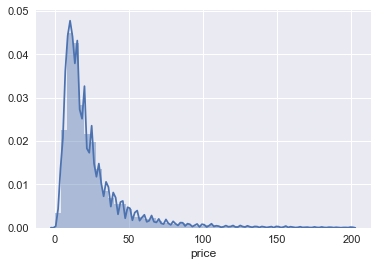

In [13]:
sns.distplot(df.price[df.price <= 200])

* Categories

Maybe Categories have some price bounds, Encode Categories to Numbers 

In [14]:
df_cate_price_group = df.groupby(['category_name'])['price'].agg(['min', 'max', 'mean'])

In [15]:
df_cate_price_group.tail()

,min,max,mean
category_name,,,
Women/Women's Handbags/Messenger & Crossbody,0.0,2006.0,58.925723
Women/Women's Handbags/Other,0.0,906.0,36.949821
Women/Women's Handbags/Satchel,0.0,1800.0,111.624518
Women/Women's Handbags/Shoulder Bag,0.0,2009.0,65.975535
Women/Women's Handbags/Totes & Shoppers,0.0,1615.0,58.385362


In [10]:
df_cate = df.category_name.str.split('/', expand=True, n=2).fillna(np.nan)
df_cate.columns = ['cate_b', 'cate_m', 'cate_s']  # category big, middle, small
df = pd.concat([df, df_cate], axis=1)

In [6]:
df_cate_b = df.cate_b.value_counts()
pct = ['{0:.2f}%'.format(y/df_cate_b.sum()*100) for y in df_cate_b.values]
bar = go.Bar(x=df_cate_b.index.values, y=df_cate_b.values, text=pct, name='',
             marker=dict(color=df_cate_b.values, colorscale='Portland', opacity=0.99))
layout = dict(title= 'Number of Items by Main Category',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Category'))
fig=dict(data=[bar], layout=layout)
# plotly.offline.iplot(fig)
plotly.offline.plot(fig, filename='./EDA_fig/02num_maincategory.html')

'file:///Users/Soo/code/gitproject/Mercari_Price/02num_maincategory.html'

In [7]:
df_cate_m = df.cate_m.value_counts().iloc[:15]
pct = ['{0:.2f}%'.format(y/df_cate_m.sum()*100) for y in df_cate_m.values][:15]
bar = go.Bar(x=df_cate_m.index.values, y=df_cate_m.values, text=pct, name='',
             marker=dict(color=df_cate_m.values, colorscale='Portland', opacity=0.99))
layout = dict(title= 'Number of Items by Sub Category (Top 15)',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Category'))
fig=dict(data=[bar], layout=layout)
# plotly.offline.iplot(fig)
plotly.offline.plot(fig, filename='./EDA_fig/03num_subcategory.html')

'file:///Users/Soo/code/gitproject/Mercari_Price/03num_subcategory.html'

In [8]:
b_cats = df.cate_b.unique()
x = [df.loc[df.cate_b==cat, 'price'] for cat in b_cats]
data = [go.Box(x=np.log(x[i]+1), name=b_cats[i]) for i in range(len(b_cats))]
layout = dict(title="Price Distribution by General Category",
              yaxis = dict(title='Frequency'),
              xaxis = dict(title='Category'))
fig = dict(data=data, layout=layout)
# plotly.offline.iplot(fig)
plotly.offline.plot(fig, filename='./EDA_fig/04price_dist_main_category.html')

'file:///Users/Soo/code/gitproject/Mercari_Price/04price_dist_main_category.html'

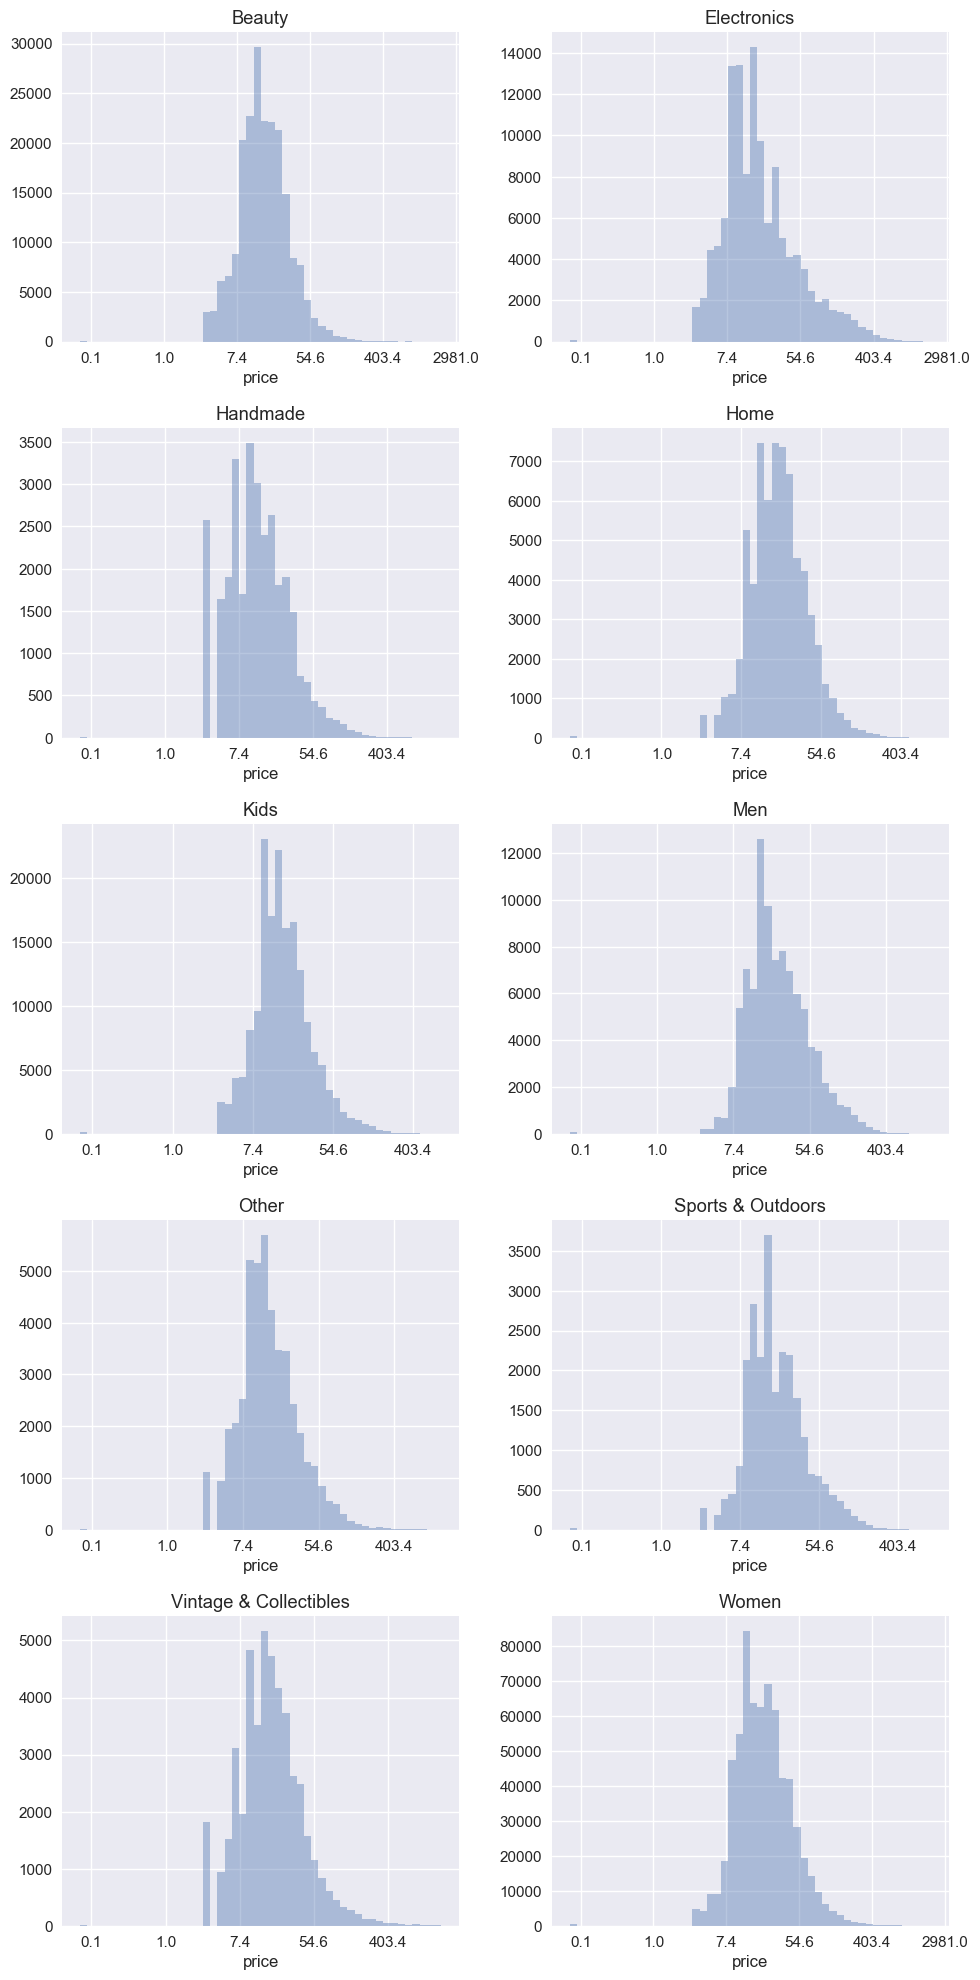

In [19]:
fig = plt.figure(figsize=(10, 20), dpi=100)
cat_len = len(df_cate_b.index)
for i in range(cat_len):
    ax = fig.add_subplot(5, 2, i+1)
    ax.set_title(df_cate_b.index[i])
    sns.distplot(np.log(df.loc[df.cate_b == df_cate_b.index[i], 'price'] + 0.1), ax=ax, kde=False)
    ax.set_xticklabels(np.exp(ax.get_xticks()).round(1))
    
plt.tight_layout()

### brand name

In [14]:
unique_brand = df.brand_name.unique()
print('number of unique brands: {}'.format(len(unique_brand)))
df_brand = df.brand_name.value_counts()
df_brand[:15]

number of unique brands: 4810


PINK                 54088
Nike                 54043
Victoria's Secret    48036
LuLaRoe              31024
Apple                17322
FOREVER 21           15186
Nintendo             15007
Lululemon            14558
Michael Kors         13928
American Eagle       13254
Rae Dunn             12305
Sephora              12172
Coach                10463
Disney               10360
Bath & Body Works    10354
Name: brand_name, dtype: int64

In [16]:
x = [df.loc[df.brand_name==brand, 'price'] for brand in df_brand[:15].index]
data = [go.Box(x=np.log(x[i]+1), name=df_brand[:15].index[i]) for i in range(len(df_brand[:15]))]
layout = dict(title="Price Distribution by Brand Name (Top 15 Counts)",
              yaxis = dict(title='Frequency'),
              xaxis = dict(title='Brand Name'))
fig = dict(data=data, layout=layout)
# plotly.offline.iplot(fig)
plotly.offline.plot(fig, filename='./EDA_fig/05price_dist_brand_name.html')

'file:///Users/Soo/code/gitproject/Mercari_Price/EDA_fig/05price_dist_brand_name.html'

Price: No Brand_name VS Brand_name

In [22]:
df['has_brand'] = (~df.brand_name.isnull()).astype(int)

In [24]:
df_has_brand_name = df.has_brand.value_counts()

In [26]:
x = [df.loc[df.has_brand==boolean, 'price'] for boolean in range(2)]
data = [go.Box(x=np.log(x[i]+1), name=i) for i in range(2)]
layout = dict(title="Price Distribution Whether has a Brand Name",
              yaxis = dict(title='Frequency'),
              xaxis = dict(title='Price'))
fig = dict(data=data, layout=layout)
# plotly.offline.iplot(fig)
plotly.offline.plot(fig, filename='./EDA_fig/06price_dist_has_brand_name.html')

'file:///Users/Soo/code/gitproject/Mercari_Price/EDA_fig/06price_dist_has_brand_name.html'